In [1]:
import os
import pandas as pd
from PIL import Image

## Dataset Path

In [2]:
train_dir = '/opt/ml/input/data/train'
test_dir = '/opt/ml/input/data/eval'

## CSV Files

In [3]:
# csv files
train_csv = pd.read_csv(os.path.join(train_dir, 'train.csv'))
test_csv = pd.read_csv(os.path.join(test_dir, 'info.csv'))

## Dataset Head

In [4]:
train_csv.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [5]:
test_csv.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


## Dataset Size & Unique Values

In [6]:
print(f'Train dataset size : {train_csv.shape}')
print(f'Test dataset size : {test_csv.shape}')

Train dataset size : (2700, 5)
Test dataset size : (12600, 2)


In [7]:
for col in train_csv.columns:
    print(col + ":" +str(len(train_csv[col].unique())))

id:2699
gender:2
race:1
age:43
path:2700


## Distribution of each attribute

In [8]:
# counter
num_female = len(train_csv[train_csv['gender'] == 'female'])
num_male = len(train_csv[train_csv['gender'] == 'male'])

age_30 = len(train_csv[train_csv['age'] < 30])
age_60 = len(train_csv[train_csv['age'] >= 60])
age_30_60 = len(train_csv.loc[(train_csv['age'] >= 30) & (train_csv['age'] < 60)])

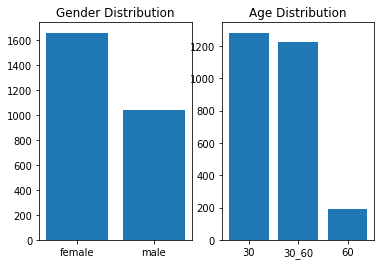

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('Gender Distribution')
ax1.bar(['female', 'male'], [num_female, num_male])
ax2.set_title('Age Distribution')
ax2.bar(['30', '30_60', '60'], [age_30, age_30_60, age_60])
plt.show()

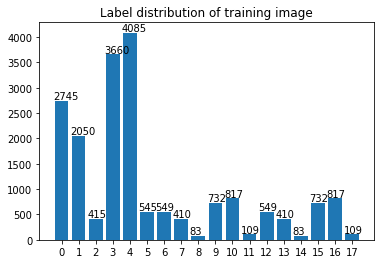

In [10]:
age_condition = [train_csv['age'] < 30, (train_csv['age'] >= 30) & (train_csv['age'] < 60), train_csv['age'] >= 60]
gender_condition = [train_csv['gender'] == 'male', train_csv['gender'] == 'female']
label_count = []

for i in range(6):
    g, a = divmod(i, 3)
    label_count.append(len(train_csv.loc[age_condition[a] & gender_condition[g]]))

label_count = [5 * c for c in label_count] + label_count + label_count

fig = plt.figure()
plt.title('Label distribution of training image')
plt.bar(list(range(18)), label_count)
for i in range(18):
    plt.text(i - 0.5, label_count[i] + 30, str(label_count[i]))
plt.xticks(list(range(18)))
plt.show()

## Checking my dataset

In [11]:
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, img_paths, csv, transform):
        self.img_paths = img_paths
        self.csv = csv
        self.transform = transform

    def __getitem__(self, index):
        # get persion id and mask info
        pid, mask_id = divmod(index, 7)
        
        # get image
        mask_images = [d for d in os.listdir(self.img_paths[pid]) if not d.startswith('._')]
        image = Image.open(os.path.join(self.img_paths[pid], mask_images[mask_id]))

        if self.transform:
            image = self.transform(image)
            
        #get label info
        gender = 0 if self.csv.gender[pid] == 'male' else 1
        age = 0 if self.csv.age[pid] < 30 else 1 if 30 <= self.csv.age[pid] < 60 else 2
        mask = 1 if 'incorrect' in mask_images[mask_id] else 2 if 'normal' in mask_images[mask_id] else 0
        
        label = 6 * mask + 3 * gender + age
        
        return label
        

    def __len__(self):
        return len(self.img_paths) * 7

In [12]:
# dataset path
train_dir = '/opt/ml/input/data/train'
test_dir = '/opt/ml/input/data/eval'

# csv files
train_csv = pd.read_csv(os.path.join(train_dir, 'train.csv'))
test_csv = pd.read_csv(os.path.join(test_dir, 'info.csv'))

# image directories
train_image_dir = os.path.join(train_dir, 'images')
test_image_dir = os.path.join(test_dir, 'images')

train_image_paths = [os.path.join(train_image_dir, img_id) for img_id in train_csv.path]
test_image_paths = [os.path.join(test_image_dir, img_id) for img_id in test_csv.ImageID]

train_dataset = TrainDataset(train_image_paths, train_csv, False)

loader = DataLoader(
    train_dataset,
    shuffle=False
)

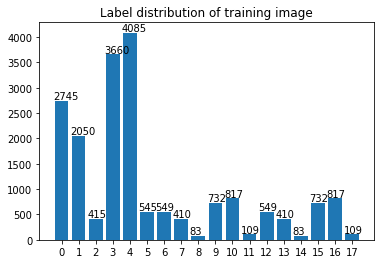

In [13]:
count = [0] * 18
for label in loader:
    count[label] += 1

fig = plt.figure()
plt.title('Label distribution of training image')
plt.bar(list(range(18)), count)
for i in range(18):
    plt.text(i - 0.5, count[i] + 30, str(count[i]))
plt.xticks(list(range(18)))
plt.show()
    